In [1]:
import helpers
import numpy as np
import matplotlib.pyplot as plt
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit_algorithms.optimizers import SPSA
from qiskit.quantum_info import Pauli

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Get Dataset

In [2]:
tr,te = helpers.get_dataset('dataset')

x = tr['time'].values.reshape(-1,1)
y = tr['displacement'].values.reshape(-1,1)

In [3]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y)

## Visualize Dataset

(10, 1) (10, 1)


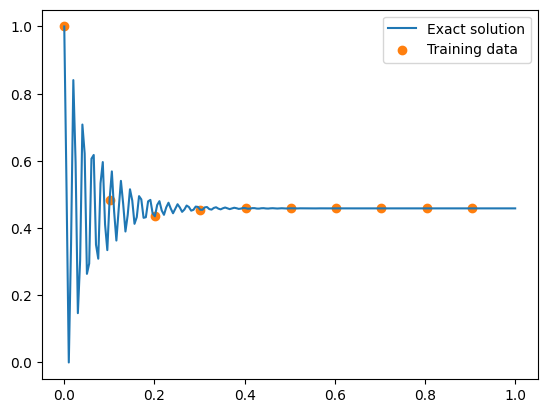

In [4]:
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Encoding

In [5]:
qc = QNNCircuit(1)
obs = Pauli('Z')
qnn = EstimatorQNN(circuit=qc, observables=obs)

In [6]:
qnn.output_shape

(1,)

In [7]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)

In [8]:
max_itr = 10
optimizer = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(qc.weight_parameters),))

In [9]:
# regressor = NeuralNetworkRegressor(
#     neural_network=qnn,
#     loss='squared_error',
#     optimizer=optimizer,
#     initial_point=initial_point
# )

In [10]:
# regressor.fit(x,y)

In [11]:
# plt.plot(spsa_loss_recorder)
# regressor.score(x, y)

## Another Trial

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

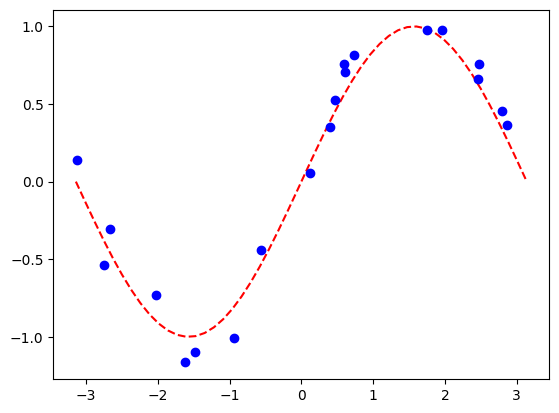

In [13]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

In [14]:
import torch

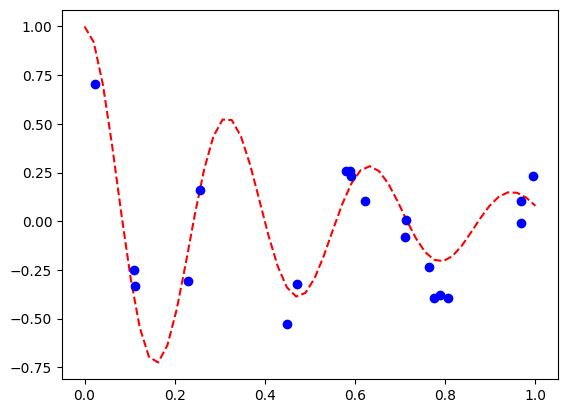

In [15]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    x = torch.tensor(x)
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y.numpy()

d, w0 = 2, 20

# get the analytical solution over the full domain
num_samples = 20
start, end = 0, 1
eps = 0.2
X_ = np.linspace(start, end, num=50).reshape(50, 1)
f = lambda x: oscillator(d, w0, x)

X = (end - start) * algorithm_globals.random.random([num_samples, 1]) + start
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)



plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

In [16]:

# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# construct QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc, input_gradients=True)

In [17]:
# callback function that draws a live plot when the .fit() method is called
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
import torch.nn as nn
from qiskit_machine_learning.connectors import TorchConnector

In [27]:
class QuantumNetwork(nn.Module):
    def __init__(self, qn):
        super(QuantumNetwork, self).__init__()
        
        self.qnn_torch = TorchConnector(qn)
    
    def forward(self, x):
        x = self.qnn_torch(x)
        # x = self.linear(x)
        return x

In [20]:
from qiskit_machine_learning.utils.loss_functions import Loss

In [37]:
phy_model = QuantumNetwork(qn = regression_estimator_qnn)

class CustomLoss(Loss):
    r"""
    This class computes the L2 loss (i.e. squared error) for each sample as:

    .. math::

        \text{L2Loss}(predict, target) = \sum_{i=0}^{N_{\text{elements}}} (predict_i - target_i)^2.

    """
    def __init__(self) -> None:
        super().__init__()
        self.phy_model = phy_model
        self.x_physics = torch.linspace(0,1, 30).view(-1,1).requires_grad_(True) # sample locations over the problem domain

    def evaluate(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:

        
        # delta, omega0 = 2.0, 20.0
        # mu, k = 2 * delta, pow(omega0, 2)
        # yhp = phy_model(self.x_physics)
        # dx  = torch.autograd.grad(yhp, self.x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        # dx2 = torch.autograd.grad(dx,  self.x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        # physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        # loss2 = (1e-4)*torch.mean(physics**2)

        self._validate_shapes(predict, target)

        if len(predict.shape) <= 1:
            return (predict - target) ** 2
        else:
            n = len(predict.shape)
            return (np.linalg.norm(predict - target, axis=tuple(range(1, len(predict.shape)))) ** 2) / n


    def gradient(self, predict: np.ndarray, target: np.ndarray) -> np.ndarray:
        self._validate_shapes(predict, target)
        n = n = len(predict.shape)

        return (2 * (predict - target)) / n

In [38]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss=CustomLoss(),
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
    warm_start=True
)

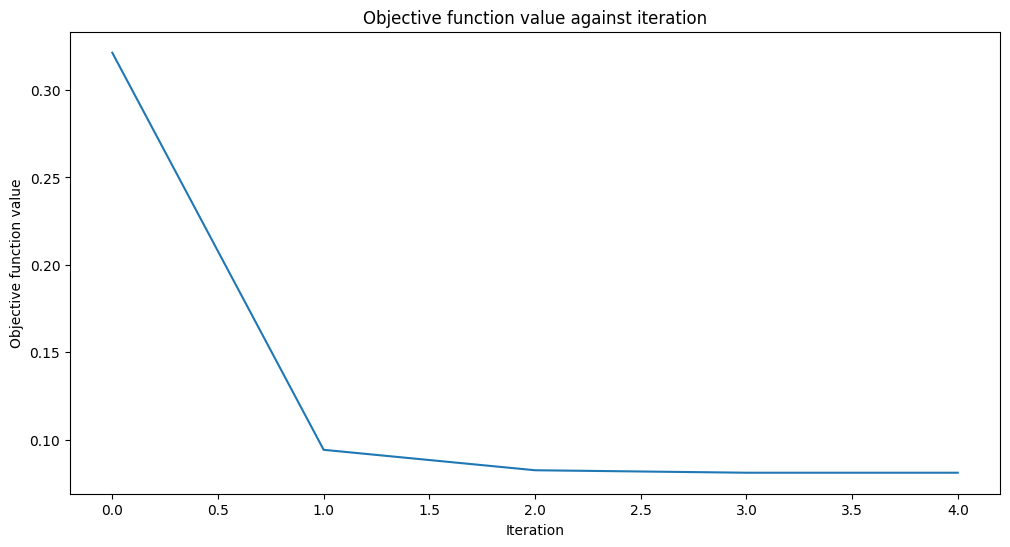

-0.7272319223787662

In [39]:
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
objective_func_vals = []
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

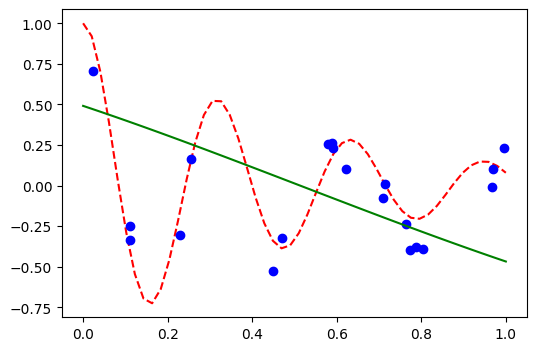

In [40]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

# Another Trial

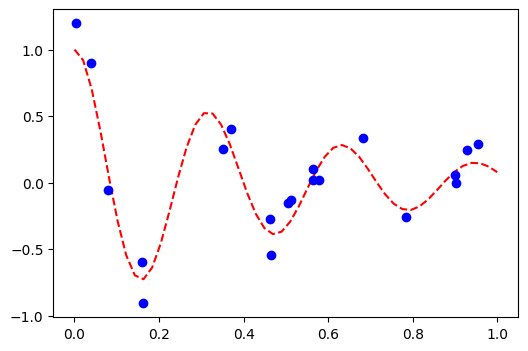

In [53]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
lb, ub = 0, 1
# f = lambda x: np.sin(x)
f = lambda x: oscillator(d, w0, x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

In [54]:
# Construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# Construct simple parameterized ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Construct QNN
qnn3 = EstimatorQNN(circuit=qc, input_params=[param_x], weight_params=[param_y])

# Set up PyTorch module
# Reminder: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights)

In [55]:
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS


In [56]:
# Define optimizer and loss function
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model3.train()  # set model to training mode

# Define objective function
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model3(Tensor(X)), Tensor(y))  # Compute batch loss
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer
optimizer.step(closure)

18.663358688354492
5.764955997467041
8.21341609954834
5.502357482910156
5.501618385314941
5.501611709594727


tensor(18.6634, grad_fn=<MseLossBackward0>)

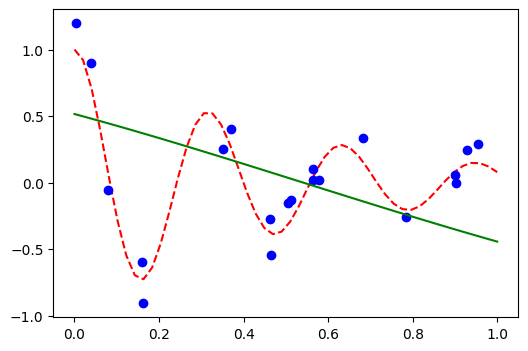

In [57]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot data
plt.plot(X, y, "bo")

# Plot fitted line
model3.eval()
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()

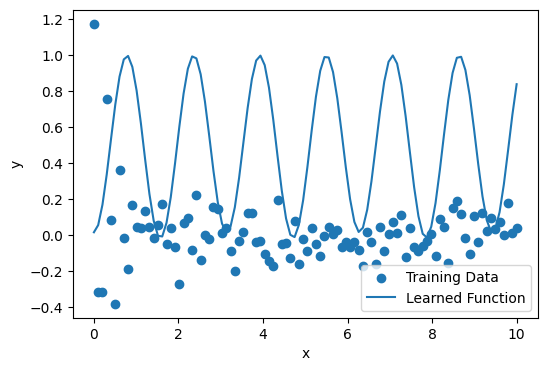

In [62]:
import numpy as np
import torch
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils.loss_functions import Loss

# Define the damped harmonic oscillator function
def damped_harmonic_oscillator(x, d, w0):
    return np.exp(-d * x) * np.cos(w0 * x)

# Generate training data
np.random.seed(0)
num_samples = 100
x_train = np.linspace(0, 10, num_samples)
y_train = damped_harmonic_oscillator(x_train, 2, 20) + np.random.normal(0, 0.1, num_samples)

# Define the QNN circuit
qc = QNNCircuit(1)

# Define the EstimatorQNN
qnn = EstimatorQNN(circuit=qc, input_gradients=True)

# Define the TorchConnector
connector = TorchConnector(qnn)

# Define the custom loss function
class CustomLoss(Loss):
    def evaluate(self, predict, target):
        return torch.mean((predict - target) ** 2)
    
    def gradient(self, predict, target):
        return super().gradient(predict, target)

# Convert the training data to tensors
x_train_tensor = torch.tensor(x_train.reshape(-1, 1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

# Define the model
# model = connector.to_torch_model()
class Model(nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.nn = connector

    def forward(self, x):
        return self.nn(x)
    
model = Model()


# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = CustomLoss()

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(x_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

# Plot the training data and the learned function
import matplotlib.pyplot as plt

x_test = np.linspace(0, 10, 100)
x_test_tensor = torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32)
y_pred = model(x_test_tensor).detach().numpy()

plt.scatter(x_train, y_train, label='Training Data')
plt.plot(x_test, y_pred, label='Learned Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
